<a href="https://colab.research.google.com/github/Ashish-sinh/covid19_Classifier/blob/main/Prediction_of_the_Covid_19_from_the_X_ray_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# first make kaggel directory and upload kaggel.json file from your computer :
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
# paste the kaggle url api refrences : for download
!kaggle datasets download -d khoongweihao/covid19-xray-dataset-train-test-sets

100% 84.0M/84.3M [00:06<00:00, 18.6MB/s]
100% 84.3M/84.3M [00:06<00:00, 14.0MB/s]


In [ ]:
# first import nessecory lib :

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import shutil
import zipfile

In [ ]:
# unzip the data :
import zipfile
zip_ref = zipfile.ZipFile('covid19-xray-dataset-train-test-sets.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# give the path of normal image folder  and  pneumonia

normal_folder  = '/content/xray_dataset_covid19/test/NORMAL'
pneumonia_folder = '/content/xray_dataset_covid19/test/PNEUMONIA'

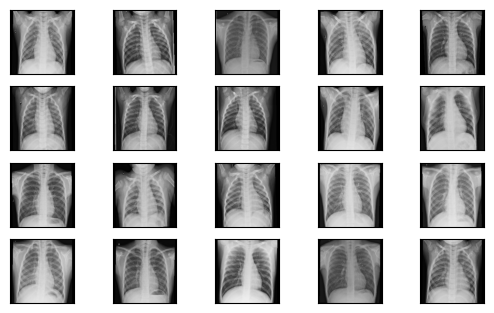

In [ ]:
# print the image of the normal X_ray  :
from tensorflow.keras.preprocessing import image
i = 0
for image_path in os.listdir(normal_folder) :
  plt.subplot(5,5,i+1)
  img = image.load_img ( normal_folder+'/'+image_path , target_size  = (200,200,3))
  plt.imshow(img)
  plt.xticks ([])
  plt.yticks ([])
  i+=1

plt.show()

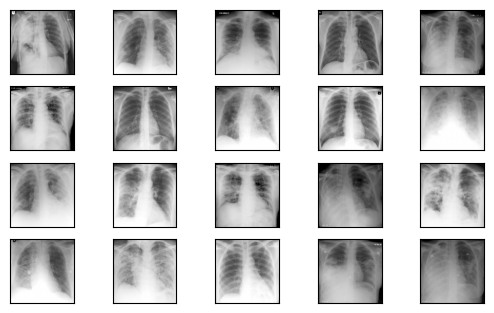

In [ ]:
# load the pneumonea images :

i =0
for image_path in os.listdir(pneumonia_folder ) :
  img = image.load_img ( pneumonia_folder+'/'+image_path , target_size = (200,200,3))
  plt.subplot(5,5,i+1)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  i+=1
plt.show()



In [ ]:
# import the convolution base of the VGG16 model :

from tensorflow.keras.applications.vgg16  import VGG16

convolution_base = VGG16 (
    weights = 'imagenet' ,
    input_shape = (200,200,3) ,
    include_top = False
)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
convolution_base.summary() # see the summary :

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
# make the trainable params of fifth block of the convolution base for the feature extraction :
for layer in convolution_base.layers :
  if 'block5' in layer.name :
    layer.trainable = True
  else :
    layer.trainable = False

# print the results:
for layer in convolution_base.layers :
  print(layer.name , layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
# creat the image augmentation generator :

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator (
    rescale = 1./255 ,
    rotation_range = .2 ,
    zoom_range = 0.2 ,
    shear_range = 0.2 )

test_generator = ImageDataGenerator (
     rescale = 1./255
)

In [ ]:
# creat the train_data  and test data :

train_data = train_generator.flow_from_directory (
    directory = '/content/xray_dataset_covid19/train' , # copy the path from direcroy :
    target_size = (200,200) ,
    class_mode = 'binary' ,
    batch_size = 64
)

test_data = test_generator.flow_from_directory(
    directory = '/content/xray_dataset_covid19/test' ,
    target_size = (200,200) ,
    class_mode = 'binary',
    batch_size = 64
)

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten , Dense , Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential ()

model.add(convolution_base)

model.add(Flatten())
model.add(Dense(512 , activation = 'relu' , kernel_initializer = 'HeNormal'))
model.add(Dropout(0.3))
model.add(Dense(512 , activation = 'relu' , kernel_initializer = 'HeNormal'))
model.add(Dropout(0.5))
model.add(Dense(2 , activation = 'softmax' , kernel_initializer = 'HeNormal'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 1

In [ ]:
# compile the model :

model.compile(optimizer = 'adam' ,
              loss = tf.keras.losses.SparseCategoricalCrossentropy() ,
              metrics = ['accuracy'] )

In [ ]:
history = model.fit(train_data ,
                    epochs = 25 ,
                    validation_data = test_data )

Epoch 1/25
3/3 [==============================] - 31s 7s/step - loss: 0.8558 - accuracy: 0.6014 - val_loss: 3.5562 - val_accuracy: 0.5000
Epoch 2/25
3/3 [==============================] - 6s 2s/step - loss: 1.7620 - accuracy: 0.5338 - val_loss: 1.0480 - val_accuracy: 0.5000
Epoch 3/25
3/3 [==============================] - 5s 1s/step - loss: 0.8549 - accuracy: 0.6014 - val_loss: 0.6014 - val_accuracy: 0.5750
Epoch 4/25
3/3 [==============================] - 7s 2s/step - loss: 0.6923 - accuracy: 0.6149 - val_loss: 0.5494 - val_accuracy: 0.5000
Epoch 5/25
3/3 [==============================] - 5s 2s/step - loss: 0.4113 - accuracy: 0.8176 - val_loss: 0.6168 - val_accuracy: 0.6000
Epoch 6/25
3/3 [==============================] - 5s 2s/step - loss: 0.3704 - accuracy: 0.8108 - val_loss: 0.6015 - val_accuracy: 0.6500
Epoch 7/25
3/3 [==============================] - 6s 3s/step - loss: 0.2562 - accuracy: 0.8716 - val_loss: 0.2758 - val_accuracy: 0.9250
Epoch 8/25
3/3 [========================

In [ ]:
import pickle
model.save('X-ray_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


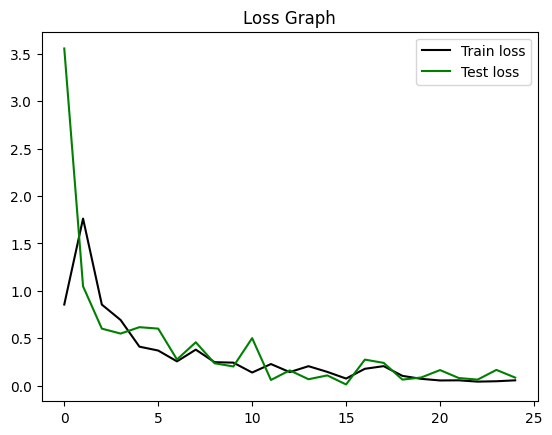

In [ ]:
# plot the Loss Graph :

plt.plot(history.history['loss'] , label = 'Train loss' , color = 'black')
plt.plot(history.history['val_loss'] , label = 'Test loss' , color = 'green')
plt.legend()
plt.title('Loss Graph')
plt.show()

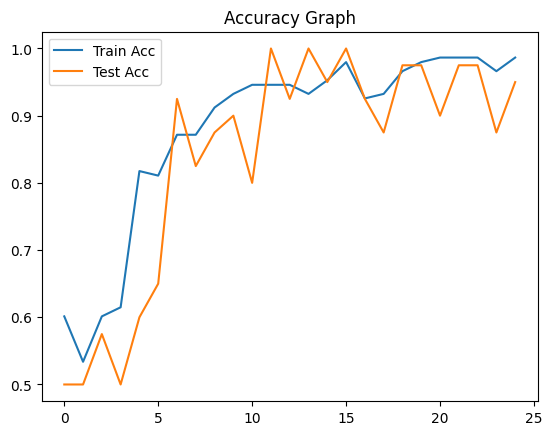

In [ ]:
# print the Acc Graph :

plt.plot(history.history['accuracy'] , label = 'Train Acc' )
plt.plot(history.history['val_accuracy'] , label = 'Test Acc')
plt.legend()
plt.title('Accuracy Graph')
plt.show()

In [ ]:
loss , acc = model.evaluate (train_data)

3/3 [==============================] - 4s 1s/step - loss: 0.0266 - accuracy: 0.9865


In [ ]:
print('Accuracy of our model is : %.2f '% acc)
print('Loss of our model is : %.2f' %loss )

Accuracy of our model is : 0.99 
Loss of our model is : 0.03


In [ ]:
from PIL import Image , ImageOps

path  = '/content/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day17.jpeg'

In [ ]:
from tensorflow.keras.preprocessing import image

img = image.load_img(path , target_size = (200,200,3))
x = image.img_to_array(img)
x = np.expand_dims(x , axis = 0)
x.shape

(1, 200, 200, 3)

In [ ]:
model.predict(x)

1/1 [==============================] - 2s 2s/step


array([[0., 1.]], dtype=float32)

In [ ]:
file_path = '/content/xray_dataset_covid19/test/PNEUMONIA'
for path in os.listdir(file_path) :
  img = image.load_img(file_path+'/'+path , target_size = (200,200,3))
  x = image.img_to_array(img)
  x = np.expand_dims(x , axis = 0)
  pred = model.predict(x)
  print(pred)
  print(np.argmax(pred))
  print()



1/1 [==============================] - 0s 18ms/step
[[0. 1.]]
1

1/1 [==============================] - 0s 18ms/step
[[0. 1.]]
1

1/1 [==============================] - 0s 21ms/step
[[0. 1.]]
1

1/1 [==============================] - 0s 20ms/step
[[1. 0.]]
0

1/1 [==============================] - 0s 19ms/step
[[0. 1.]]
1

1/1 [==============================] - 0s 21ms/step
[[1.0000000e+00 1.2080477e-10]]
0

1/1 [==============================] - 0s 22ms/step
[[1. 0.]]
0

1/1 [==============================] - 0s 19ms/step
[[0. 1.]]
1

1/1 [==============================] - 0s 18ms/step
[[1.0000000e+00 4.1759055e-33]]
0

1/1 [==============================] - 0s 21ms/step
[[0. 1.]]
1

1/1 [==============================] - 0s 33ms/step
[[0. 1.]]
1

1/1 [==============================] - 0s 36ms/step
[[0. 1.]]
1

1/1 [==============================] - 0s 29ms/step
[[0.29681587 0.7031841 ]]
1

1/1 [==============================] - 0s 35ms/step
[[0. 1.]]
1

1/1 [=========================

In [ ]:
file_path = '/content/xray_dataset_covid19/test/NORMAL'
for path in os.listdir(file_path) :
  img = image.load_img(file_path+'/'+path , target_size = (200,200,3))
  x = image.img_to_array(img)
  x = np.expand_dims(x , axis = 0)
  pred = model.predict(x)
  print(pred)
  print()

1/1 [==============================] - 0s 30ms/step
[[1. 0.]]

1/1 [==============================] - 0s 31ms/step
[[1. 0.]]

1/1 [==============================] - 0s 29ms/step
[[1. 0.]]

1/1 [==============================] - 0s 31ms/step
[[1. 0.]]

1/1 [==============================] - 0s 27ms/step
[[1. 0.]]

1/1 [==============================] - 0s 28ms/step
[[1. 0.]]

1/1 [==============================] - 0s 30ms/step
[[1. 0.]]

1/1 [==============================] - 0s 27ms/step
[[1. 0.]]

1/1 [==============================] - 0s 37ms/step
[[1. 0.]]

1/1 [==============================] - 0s 29ms/step
[[1. 0.]]

1/1 [==============================] - 0s 30ms/step
[[1. 0.]]

1/1 [==============================] - 0s 30ms/step
[[1. 0.]]

1/1 [==============================] - 0s 31ms/step
[[1. 0.]]

1/1 [==============================] - 0s 22ms/step
[[1. 0.]]

1/1 [==============================] - 0s 19ms/step
[[1. 0.]]

1/1 [==============================] - 0s 19ms/step
[[1